### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 22nd at 11.59pm CT
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from astroML.density_estimation import KNeighborsDensity
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Patch
from sklearn.cluster import KMeans
from sklearn import preprocessing

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [2]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

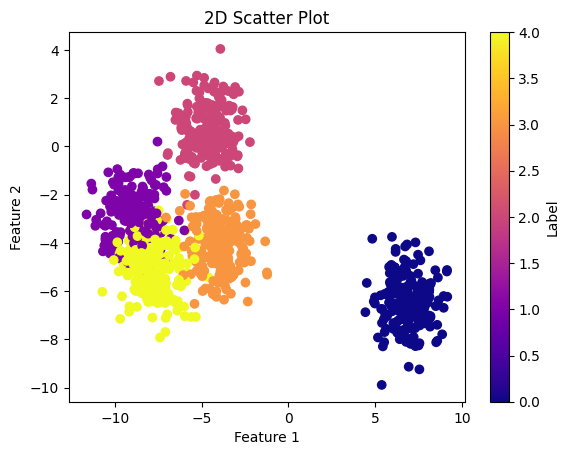

In [3]:
# SD: task 1
file = np.load("../../../homeworks/hw_data/hw6_data_1.npy") # SD: load in the file
feature_1 = file[:,0]
feature_2 = file[:,1]
label = file[:,2]
X = file[:, 0:2]

plt.scatter(feature_1, feature_2, c=label, cmap="plasma")
plt.colorbar(label="Label")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("2D Scatter Plot")
plt.show()

In [4]:
# SD: task 2
bwrange = np.linspace(0.1, 1, 30) # SD: testing 30 bandwidths from 0.1 to 1.0
K = 5 # SD: 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K)
grid.fit(X)
h_opt = grid.best_params_['bandwidth']
print("The best bandwidth is", h_opt)

The best bandwidth is 0.4724137931034482


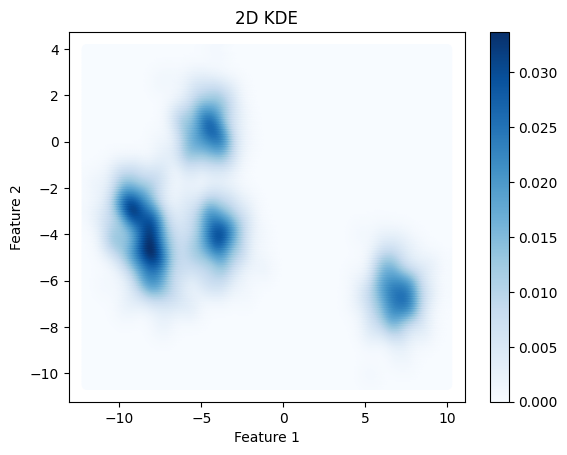

In [5]:
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt) # SD: using optimal bandwidth
kde.fit(X) # SD: fit model to data

u = np.linspace(-12,10,200)
v = np.linspace(-10.5,4,200)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T # SD: making a grid that spans the feature-space
dens = np.exp(kde.score_samples(Xgrid)) #SD: evaluating model on grid

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, cmap="Blues", edgecolor=None)
plt.colorbar()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("2D KDE")
plt.show()

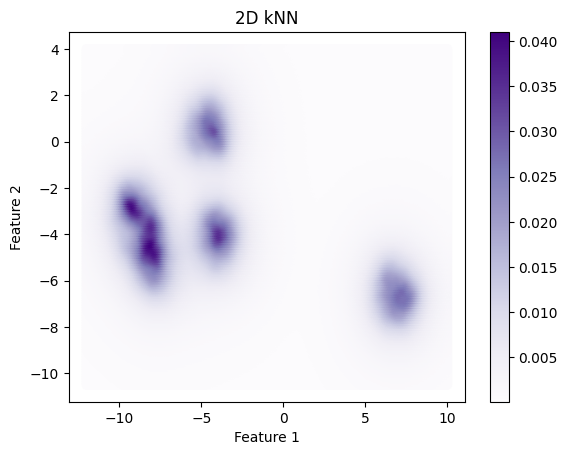

In [6]:
# SD: task 3
k = 60 # SD: <- this many nearest neighbors gives a plot similar to the KDE!

nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(X) # SD: fit model to data
dens_nbrs = nbrs.eval(Xgrid) / len(file)

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens_nbrs, cmap="Purples", edgecolor=None)
plt.colorbar()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("2D kNN")
plt.show()

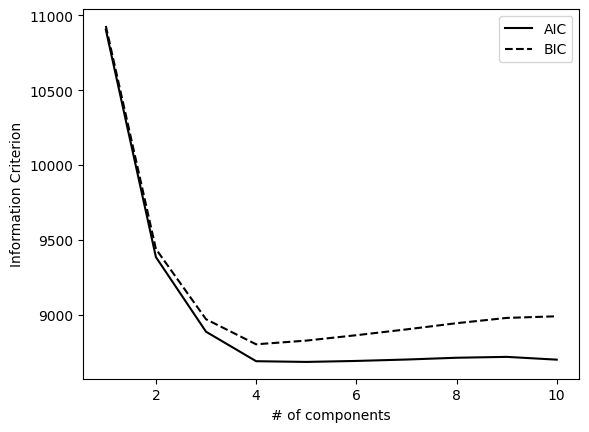

In [7]:
# SD: task 4
N = np.arange(1, 11)
models = []
for n in N:
    models.append(GaussianMixture(n).fit(X)) # SD: storing fitted model for each value of N

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

plt.plot(N, AIC, '-k', label='AIC')
plt.plot(N, BIC, '--k', label='BIC')
plt.xlabel('# of components')
plt.ylabel('Information Criterion')
plt.legend()
plt.show()

According to the BIC, the optimal number of components is 4.

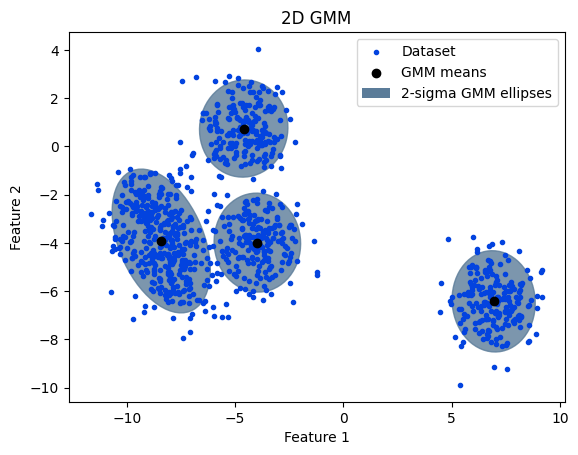

In [8]:
optimal_model = models[np.argmin(BIC)] # SD: getting the optimal fitted model
means = optimal_model.means_
covariances = optimal_model.covariances_

fig, ax = plt.subplots()

for i in range(len(means)):
    draw_ellipse(means[i], covariances[i], scales=[2], ax=ax, alpha=0.8, color="xkcd:slate blue") # SD: ellipses
plt.scatter(feature_1, feature_2, c='xkcd:blue', marker=".", label="Dataset") # SD: original data
plt.scatter(means[:, 0], means[:, 1], c='xkcd:black', marker="o", label="GMM means") # SD: GMM mean centers

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("2D GMM")
handles, labels = ax.get_legend_handles_labels()
handles.append(Patch(facecolor='xkcd:slate blue', label='2-sigma GMM ellipses')) # SD: printing the label this way so I don't get 4 "2-sigma ..."
ax.legend(handles=handles)
plt.show()

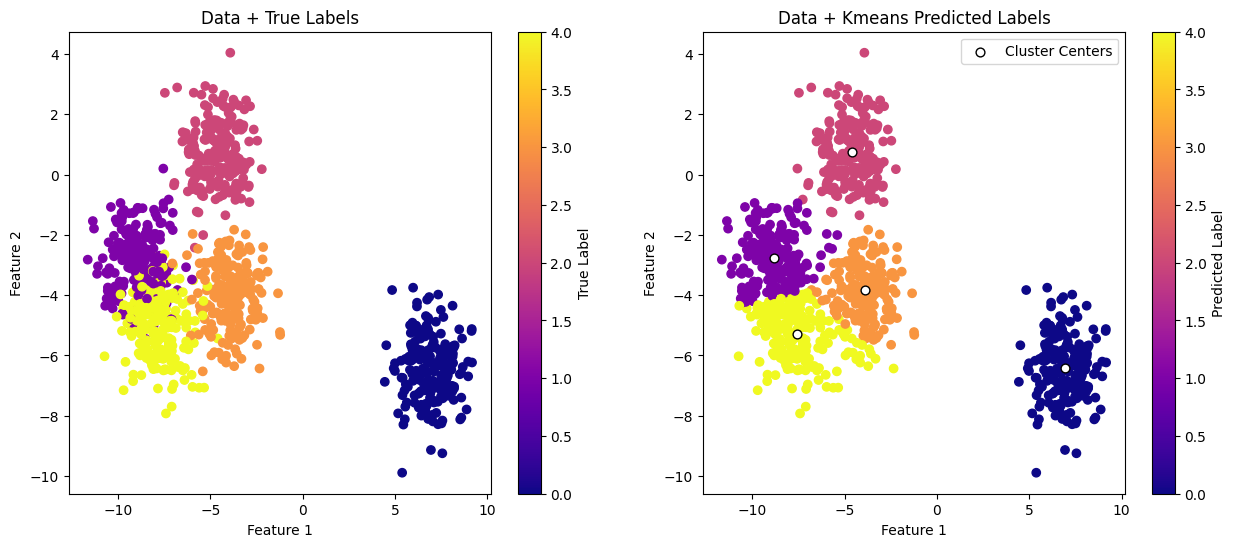

In [16]:
# SD: task 5
scaler = preprocessing.StandardScaler() # SD: using standard scaling
clf = KMeans(5) # SD: 5 clusters
clf.fit(scaler.fit_transform(X)) # SD: fitting on scaled values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sc1 = ax1.scatter(feature_1, feature_2, c=label, cmap="plasma") # SD: original data

fig.colorbar(sc1, ax=ax1, label="True Label")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_title("Data + True Labels")

H = clf.predict(scaler.transform(X)) # SD: predicting labels
sc2 = ax2.scatter(feature_1, feature_2, c=H, cmap="plasma") # SD: predicted labels
fig.colorbar(sc2, ax=ax2, label="Predicted Label")

cluster_centers = scaler.inverse_transform(clf.cluster_centers_) # SD: unscaling to get cluster centers
ax2.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=40, c='w', edgecolors='k', label="Cluster Centers")

ax2.legend()
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")
ax2.set_title("Data + Kmeans Predicted Labels")
plt.show()